#### Import libraries and packages

In [1]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np
import seaborn as sns

#### Set connection with postgres database

In [14]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Select whole table as dataframe

In [15]:
sql = "SELECT * from formatted_zone.ajunt_barris_2017_21_12_06;"
df = pd.read_sql_query(sql, conn)
df.head()

,codi_districte,nom_districte,codi_barri,nom_barri
0,1,Ciutat Vella,1,el Raval
1,1,Ciutat Vella,2,el Barri Gòtic
2,1,Ciutat Vella,3,la Barceloneta
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera"
4,2,Eixample,5,el Fort Pienc


#### Remove useless columns

In [11]:
# Creo que no es necesario quitar los codigos, ya que podrian ser utiles en otros casos?

#### Check data types

In [16]:
df.dtypes

codi_districte     int64
nom_districte     object
codi_barri         int64
nom_barri         object
dtype: object

#### Correct data types

In [17]:
df['codi_districte'] = df['codi_districte'].astype("category")
df['nom_districte'] = df['nom_districte'].astype("category")
df['codi_barri'] = df['codi_barri'].astype("category")
df['nom_barri'] = df['nom_barri'].astype("category")

In [19]:
df.dtypes

codi_districte    category
nom_districte     category
codi_barri        category
nom_barri         category
dtype: object

#### Quality analysis

In [28]:
df.isna().any().any()

False

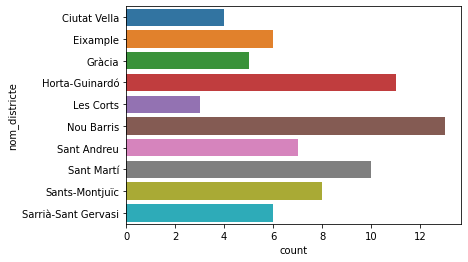

In [42]:
sns.countplot(y='nom_districte', data = df, orient= 'h')

The plot might look unbalanced, but that's how the districts have been distributed in Barcelona.

### Load districts table into trusted zone

##### Create trusted_zone schema if it does not exist

In [20]:
create_trusted_zone = """CREATE SCHEMA IF NOT EXISTS trusted_zone;"""
cursor.execute(create_trusted_zone)
conn.commit()

##### Create new table in PostgreSQL database

In [26]:
sqlCreateTable = """CREATE TABLE IF NOT EXISTS trusted_zone.ajunt_barris_2017_21_12_06 (
    NOM_DISTRICTE VARCHAR(50), 
    NOM_BARRI VARCHAR(50)
);"""
cursor.execute(sqlCreateTable)
conn.commit()

##### Insert rows into table

In [22]:
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("The dataframe was correctly inserted")
    cursor.close()

In [23]:
execute_values(conn, df, 'trusted_zone.ajunt_barris_2017_21_12_06')

The dataframe was correctly inserted


##### Check correct insertion

In [27]:
sql = "SELECT * from trusted_zone.ajunt_barris_2017_21_12_06;"
pd.read_sql_query(sql, conn)

,codi_districte,nom_districte,codi_barri,nom_barri
0,1,Ciutat Vella,1,el Raval
1,1,Ciutat Vella,2,el Barri Gòtic
2,1,Ciutat Vella,3,la Barceloneta
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera"
4,2,Eixample,5,el Fort Pienc
...,...,...,...,...
141,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou
142,10,Sant Martí,70,el Besòs i el Maresme
143,10,Sant Martí,71,Provençals del Poblenou
144,10,Sant Martí,72,Sant Martí de Provençals
